In [25]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)

In [26]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

db = client.database
collection = db.adsE_collection

In [35]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'Ru', 'face':'001'})
dictlis.append({'element':'Ru', 'face':'100'})
dictlis.append({'element':'Zn', 'face':'001'})
dictlis.append({'element':'Zn', 'face':'100'})

dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})
dictlis.append({'element':'ZnCu', 'face':'100'})
dictlis.append({'element':'ZnCu', 'face':'110'})
dictlis.append({'element':'CuSn', 'face':'100'})
dictlis.append({'element':'CuSn', 'face':'001'})

In [36]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        du = dataset_utilizer('adsE_method1', **dictlis[i])
        inst.append(du)
        dfall.append(du.dfall)
        df.append(du.df)
        dfpred.append(du.dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

Error: {'element': 'Ru', 'face': '100'}
Error: {'element': 'Zn', 'face': '100'}
Error: {'element': 'ZnCu', 'face': '100'}
Error: {'element': 'ZnCu', 'face': '110'}
Error: {'element': 'CuSn', 'face': '100'}
Error: {'element': 'CuSn', 'face': '001'}


In [37]:
query('Au_111_u2_RPBE_no035_CO_n4_d3_all.traj', 'local')

Atoms(symbols='Au12COCOCOCO', pbc=True, cell=[[5.93603382, 0.0, 0.0], [-2.96801691, 5.14075608, 0.0], [0.0, 0.0, 36.35063486]], constraint=FixAtoms(indices=[0, 3, 6, 9]), calculator=SinglePointCalculator(...))

In [38]:
dfall[9][dfall[9]['numberofads']==4]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
6,5e7e2d2ba222761ffba74925,Au_111_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-86.250727,-29.59572,-14.485436,1.286738,0.321684,0.321684,1.555925,0.554171,-0.205839,30.515702,0.13108,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3.0,0.0,24.0
8,5e7e2d35a222761ffba74929,Au_111_u2_RPBE_no006_CO_n4_d3.traj,no,yes,Au,111,2,RPBE,CO,4,1.0,4,-85.434536,-29.59572,-14.485436,2.102928,0.525732,0.525732,2.380634,0.280551,-0.139564,30.515702,0.13108,"[1, 1, 0, 0]","[1, 1, 0, 0]",no,no,yes,yes,2.0,4.0,4.0
20,5e7e2d80a222761ffba74941,Au_111_u2_RPBE_no019_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-84.616088,-29.59572,-14.485436,2.921377,0.730344,0.730344,1.555927,0.006931,0.339630,30.515702,0.13108,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,2.0,8.0,72.0
22,5e7e2d91a222761ffba74945,Au_111_u2_RPBE_no021_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-83.549198,-29.59572,-14.485436,3.988267,0.997067,0.997067,2.380638,0.006931,0.400175,30.515702,0.13108,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,2.0,8.0,72.0
31,5e7e2dc9a222761ffba74957,Au_111_u2_RPBE_no031_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-84.009429,-29.59572,-14.485436,3.528035,0.882009,0.882009,1.555593,-0.034824,0.501817,30.515702,0.13108,"[2, 2, 2, 2]","[2, 2, 2, 2]",yes,yes,yes,yes,2.0,24.0,72.0
34,5e7e2ddca222761ffba7495d,Au_111_u2_RPBE_no035_CO_n4_d3.traj,yes,yes,Au,111,2,RPBE,CO,4,1.0,4,-83.723580,-29.59572,-14.485436,3.813885,0.953471,0.953471,1.555593,0.203265,0.513757,30.515702,0.13108,"[3, 3, 3, 3]","[3, 3, 3, 3]",yes,yes,yes,yes,2.0,24.0,72.0


In [39]:
### Exclude coverage > 1.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['coverage'] <= 1.0]

### Exclude ads ene > 2.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['aveadsE/suratom'] >= -2.0]

In [32]:
# id = -2
# # dfall[id][dfall[id]['numberofads']==1]
# dfall[id]
# #dfall[id][dfall[id]['isvalid']=='yes']

In [40]:
# file = 'Au_110_u2_RPBE_no006_CO_n4_d3_all' + '.traj' 
# iatoms = init_query(file,'local')
# ratoms =query(file, 'local')

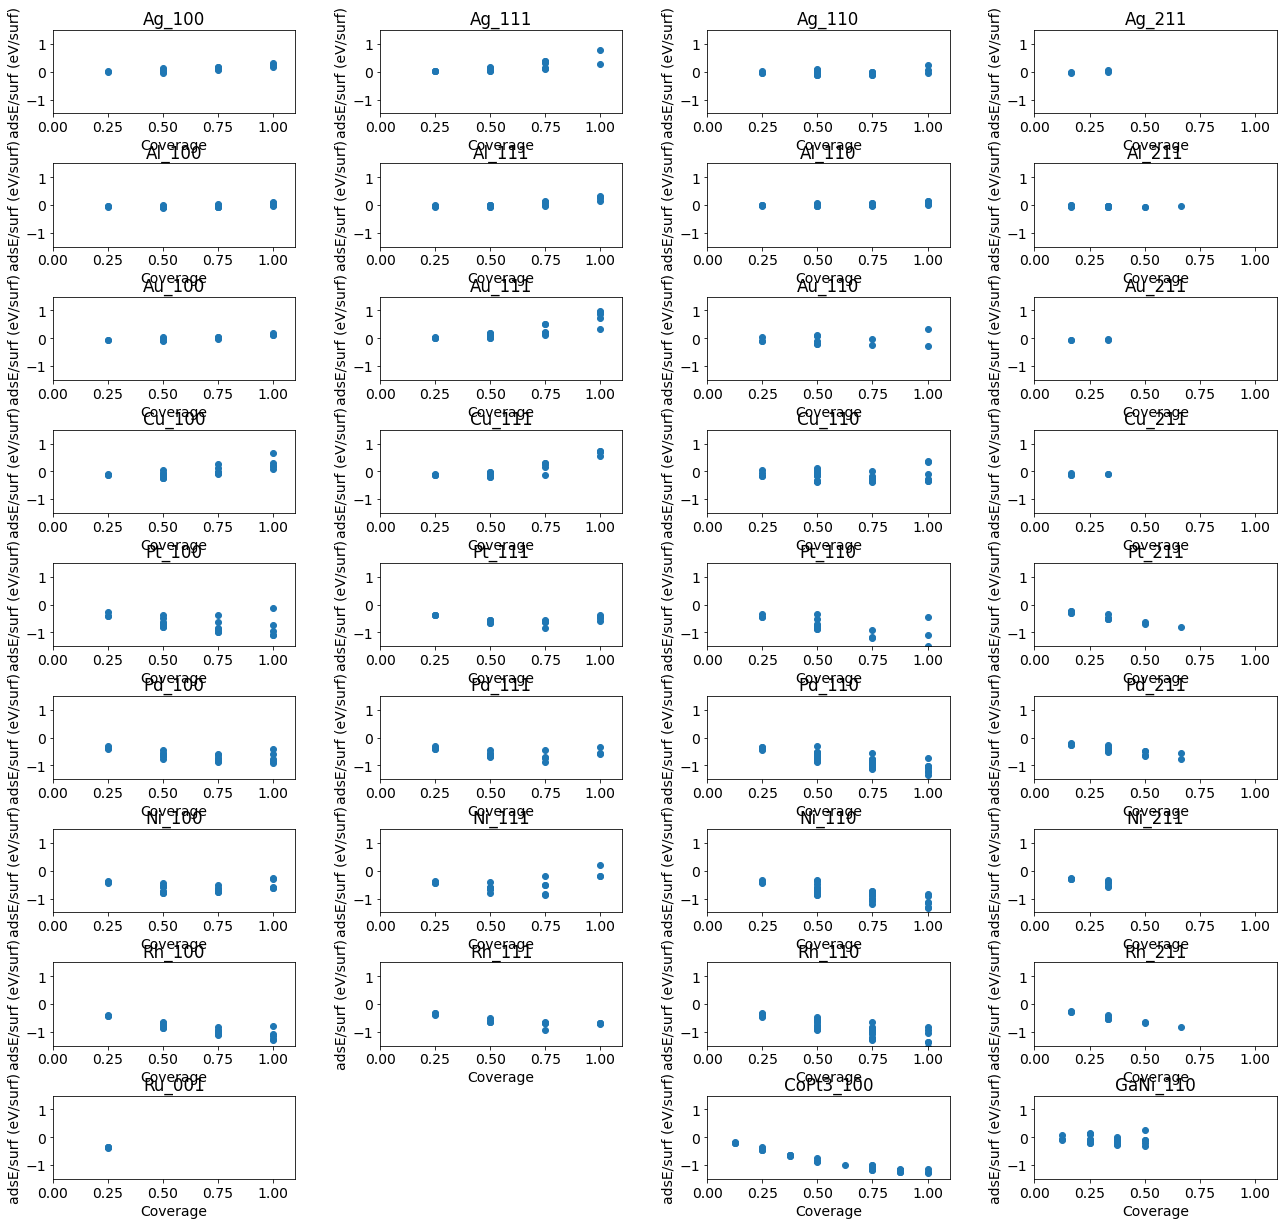

In [42]:
fig = plt.figure(figsize=(20,30))

for i in range(len(df)):
    if len(df[i])==0:
        continue
    ax = fig.add_subplot(10, 4, i+1)
    ax.plot(df[i]['coverage'], df[i]['aveadsE/suratom'], 'o')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-1.5,1.5])  
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [16]:
dfall[0]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e7e58f6a222761ffba74977,Ag_100_u2_RPBE_no001_CO_n1_d9.traj,yes,no,Ag,100,2,RPBE,CO,1,0.25,4,-47.020853,-32.474988,-14.485436,-0.060429,-0.015107,-0.060429,0.001609,NaN,NaN,35.502184,0.028167,[0],[0],yes,yes,yes,yes,None,NaN,NaN
1,5e7e58f6a222761ffba74979,Ag_100_u2_RPBE_no002_CO_n1_d9.traj,yes,no,Ag,100,2,RPBE,CO,1,0.25,4,-46.896484,-32.474988,-14.485436,0.063940,0.015985,0.063940,0.001609,NaN,NaN,35.502184,0.028167,[1],[1],yes,yes,yes,yes,None,NaN,NaN
2,5e7e58f7a222761ffba7497b,Ag_100_u2_RPBE_no002_CO_n2_d3.traj,yes,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.373971,-32.474988,-14.485436,0.071890,0.017972,0.035945,0.239696,-0.120858,-0.011737,35.502184,0.056335,"[0, 0]","[0, 0]",yes,yes,yes,yes,3,0.0,4.0
3,5e7e5904a222761ffba7497d,Ag_100_u2_RPBE_no003_CO_n1_d9.traj,no,no,Ag,100,2,RPBE,CO,1,0.25,4,-46.971725,-32.474988,-14.485436,-0.011301,-0.002825,-0.011301,0.001609,NaN,NaN,35.502184,0.028167,[2],[2],yes,no,yes,yes,None,NaN,NaN
4,5e7e5904a222761ffba7497f,Ag_100_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.670604,-32.474988,-14.485436,0.260692,0.065173,0.086897,0.494535,-0.181286,-0.013139,35.502184,0.084502,"[0, 0, 0]","[0, 0, 0]",yes,yes,yes,yes,3,0.0,8.0
5,5e7e5911a222761ffba74981,Ag_100_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,Ag,100,2,RPBE,CO,4,1.00,4,-89.715536,-32.474988,-14.485436,0.701197,0.175299,0.175299,1.027711,-0.241715,-0.021199,35.502184,0.112669,"[0, 0, 0, 0]","[0, 0, 0, 0]",yes,yes,yes,yes,3,0.0,16.0
6,5e7e591fa222761ffba74983,Ag_100_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,Ag,100,2,RPBE,CO,3,0.75,4,-75.581672,-32.474988,-14.485436,0.349625,0.087406,0.116542,0.404338,-0.056917,0.000551,35.502184,0.084502,"[1, 0, 0]","[1, 0, 0]",yes,yes,yes,yes,3,0.0,14.0
7,5e7e592ca222761ffba74985,Ag_100_u2_RPBE_no006_CO_n4_d3.traj,yes,yes,Ag,100,2,RPBE,CO,4,1.00,4,-89.429922,-32.474988,-14.485436,0.986811,0.246703,0.246703,0.849630,0.007023,0.032540,35.502184,0.112669,"[1, 1, 0, 0]","[1, 1, 0, 0]",yes,yes,yes,yes,2,4.0,24.0
8,5e7e593aa222761ffba74987,Ag_100_u2_RPBE_no007_CO_n2_d3.traj,yes,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.552238,-32.474988,-14.485436,-0.106378,-0.026594,-0.053189,-0.017165,-0.120858,0.007911,35.502184,0.056335,"[0, 0]","[0, 0]",yes,yes,yes,yes,Over 4,0.0,0.0
9,5e7e5947a222761ffba74989,Ag_100_u2_RPBE_no008_CO_n2_d3.traj,no,yes,Ag,100,2,RPBE,CO,2,0.50,4,-61.547129,-32.474988,-14.485436,-0.101269,-0.025317,-0.050634,0.067257,-0.120858,-0.011917,35.502184,0.056335,"[1, 0]","[0, 0]",yes,yes,no,yes,Over 4,0.0,0.0


In [39]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(df[i]['coverage']))))
covset

[[0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.16666666666666666, 0.3333333333333333],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.25, 0.5, 0.75, 1.0],
 [0.1666666666666

In [40]:
eneset = copy.deepcopy(covset)
for i in range(len(covset)):
    for j in range(len(covset[i])):
        eneset[i][j] = df[i][df[i]['coverage'] == covset[i][j]]['aveadsE/suratom'].min()

IndexError: index out of bounds

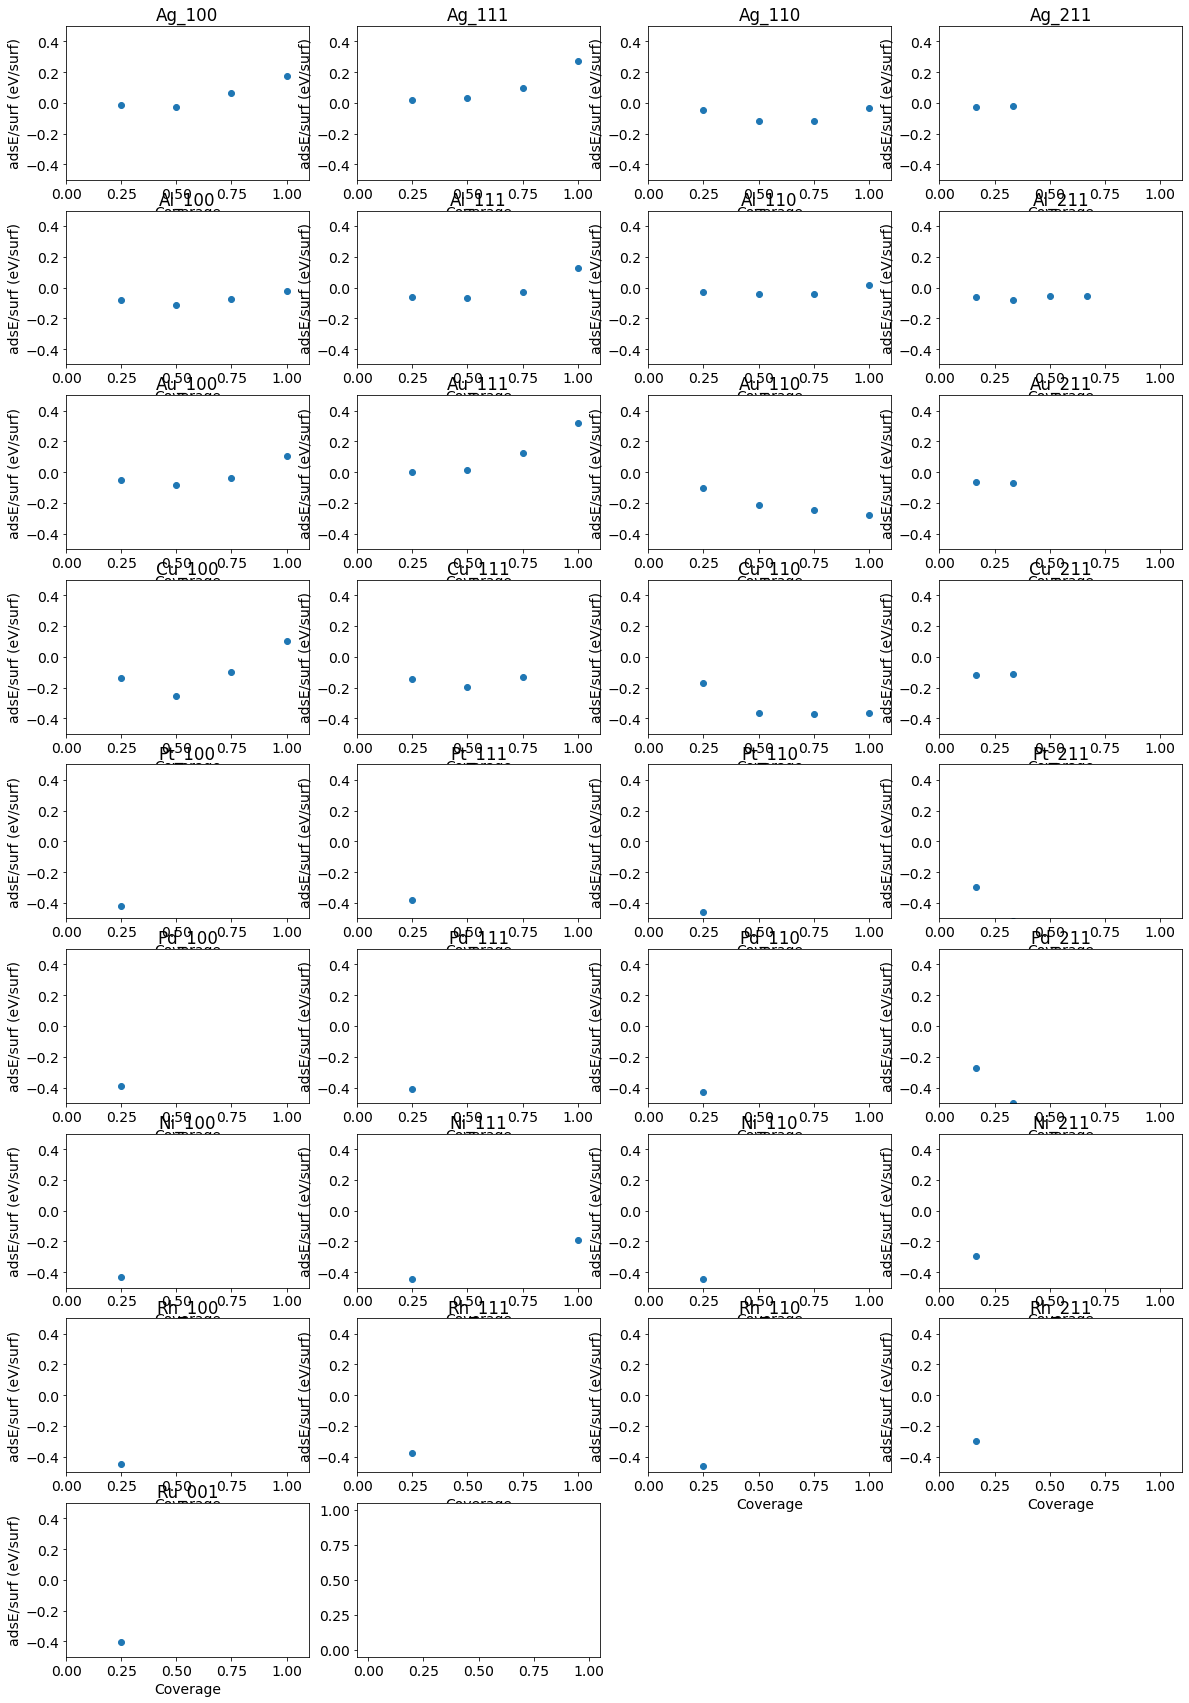

In [41]:
fig = plt.figure(figsize=(20,30))

for i in range(len(df)):
    ax = fig.add_subplot(9, 4, i+1)
    ax.plot(covset[i], eneset[i], 'o')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-0.5,0.5])    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [23]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [24]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(eneset)):
    tmp = []
    for p in prange:
        tmp.append(eneset[i]-kb*T*np.log(p/Pref)*np.array(covset[i]))
    pres.append(tmp)

ValueError: num must be 1 <= num <= 20, not 21

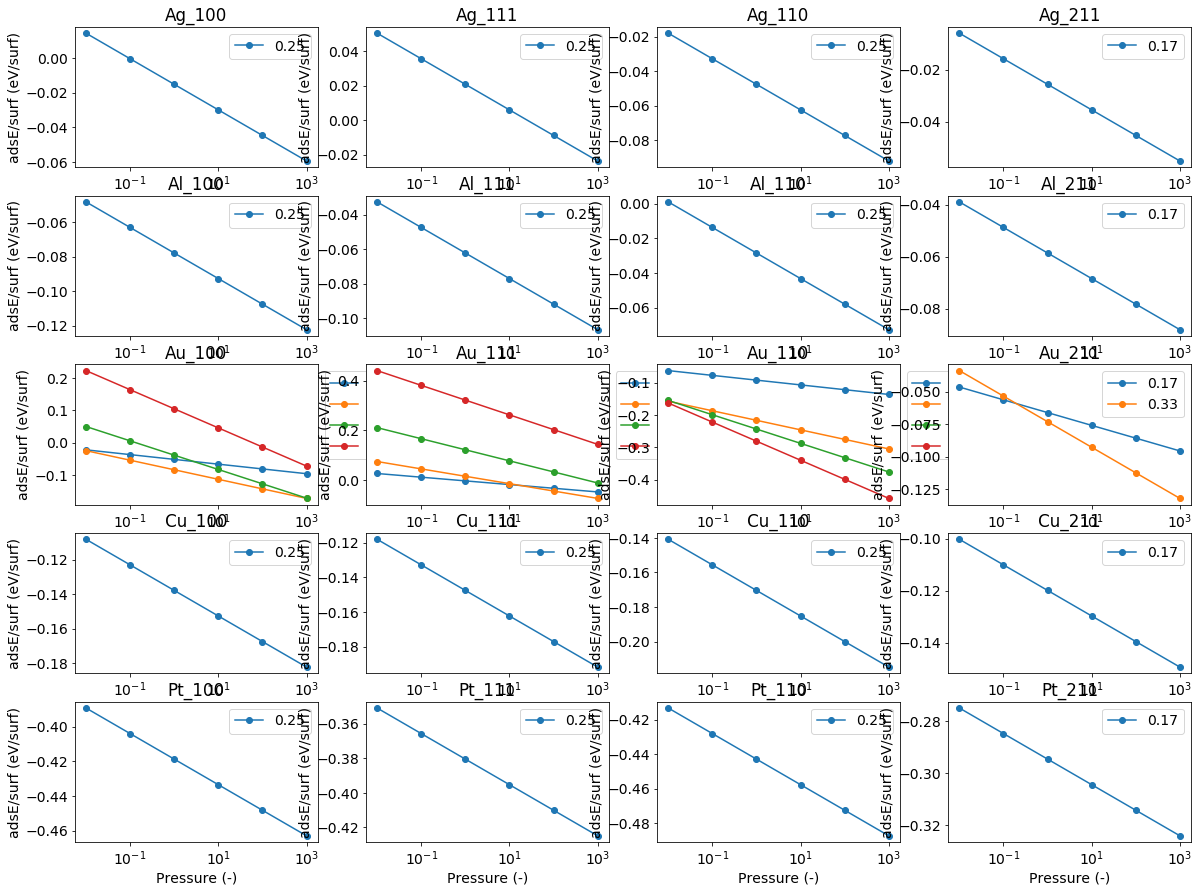

In [97]:
# for i in range(len(pres)):
#     plt.plot(prange, pres[i], 'o-')
#     plt.xscale('log')
#     plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     plt.xlabel('Pressure (-)')
#     plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
# #     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
#     plt.show()
    
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('Pressure (-)')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 1))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.8, wspace=0.7)
# plt.savefig('')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression()

In [ ]:
def linearfit(X, y):
    index = 1
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [ ]:
densityset = []
for i in range(len(covset)):
    densityset.append(covset[i]/df[i][df[i]['unitlength'] ==1]['area'][0])

In [ ]:
def func(X, slope, a2, a3, a4, a5, a6, a7, a8):
    return slope*X + a2*X**2 + a3*X**3 + a4*X**4 + a5*X**5 + a6*X**6 + a7*X**7 + a8*X**8

In [ ]:
def MSE(A):
    a2, a3, a4, a5, a6, a7, a8 = A
    mse = 0
    for i in range(0,6):
        X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
        X = np.array(X)
        y = np.array(y)    
        X_ = X.reshape(-1, 1)
        fitres, slope = linearfit(X_, y)

        mse += sum((y - func(X, slope, a2, a3, a4, a5, a6, a7, a8))**2)
    return mse

In [ ]:
from scipy.optimize import minimize
sol = minimize(MSE, [1,1,1,1,1,1,1])
sol.x

In [ ]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)

    ax.plot(X, y, 'o')
    ax.plot(X, func(X, slope, *sol.x), '-')
    ax.set_title('{}_{}'.format(df[i]['element'][0], df[i]['face'][0]))
    ax.set_xlabel('density (/A^2)')
    ax.set_ylabel('adsE/sur (eV/surf)')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()